In [ ]:
import torch
import time
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal

'''
SHD dataset as in ablation study
'''

device = get_device()

# for reproducibility
torch.manual_seed(10)

dataset = 'ibm_gestures'
total_time = 50
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to = 32,
                  crop_to=1e6)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

Running on: cuda:0
[CropTime(min=0, max=1000000.0), Downsample(time_factor=1, spatial_factor=0.25, sensor_size=None, target_size=None), ToFrame(sensor_size=(32, 32, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


### Testing all different layer types

In [3]:
num_epochs = 5

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 16, 
        'kernel_size': 4, 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 32, 
        'kernel_size': 2, 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 128, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 20, 'stride': 2, 'pruning': 3}, # Fan-in delays for the feedforward layer
    },
    {
        'type': 'Recurrent', 
        'num_out': 128, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 10, 'stride': 1}, 
    },
    {
        'type': 'MultiFeedforward', 
        'num_out': 128, # Number of neurons in this dense layer
        'num_fanin_multifeedforward': 4, # Number of fan-in connections for the multifeedforward layer
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m='normal', win=50, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn._set_layers()
snn.to(device)

Delta t: 20.0 ms


SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 16, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(16, 32, kernel_size=(2, 2), stride=(2, 2), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=5120, out_features=128, bias=False)
    )
    (4): RecurrentSNNLayer(
      (linear): Linear(in_features=1280, out_features=128, bias=False)
      (linear_rec): Linear(in_features=128, out_features=128, bias=False)
    )
    (5): MultiFeedforwardSNNLayer(
      (linear): Linear(in_features=512, out_features=128, bias=False)
    )
    (6): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=11, bias=False)
    )
  )
  (criterion): CrossEntropyLoss()
)

Epoch [1/5], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [2/1], Loss: 2.42307
Time elasped: 70.22368431091309
264
Test Loss: 2.357325792312622
Avg spk_count per neuron for all 50 time-steps 2189.003156565657
Test Accuracy of the model on the test samples: 19.697

max acc: 19.696969696969695
Epoch [2/5], learning_rates 0.001000, 0.100000
Step [2/1], Loss: 2.81414
Time elasped: 2.128368616104126
264
Test Loss: 2.3030247688293457
Avg spk_count per neuron for all 50 time-steps 2109.7916666666665
Test Accuracy of the model on the test samples: 24.621

max acc: 24.62121212121212
Epoch [3/5], learning_rates 0.001000, 0.100000
Step [2/1], Loss: 2.19265
Time elasped: 2.1720926761627197
264
Test Loss: 2.086522340774536
Avg spk_count per neuron for all 50 time-steps 1958.1047979797981
Test Accuracy of the model on the test samples: 26.136

max acc: 26.136363636363637
Epoch [4/5], learning_rates 0.001000, 0.100000
Step [2/1], Loss: 1.80159
Time elasped: 2.147198438644409
264
Test Loss: 2.195781707763672
Avg spk_count per neuron for all 50 time-step

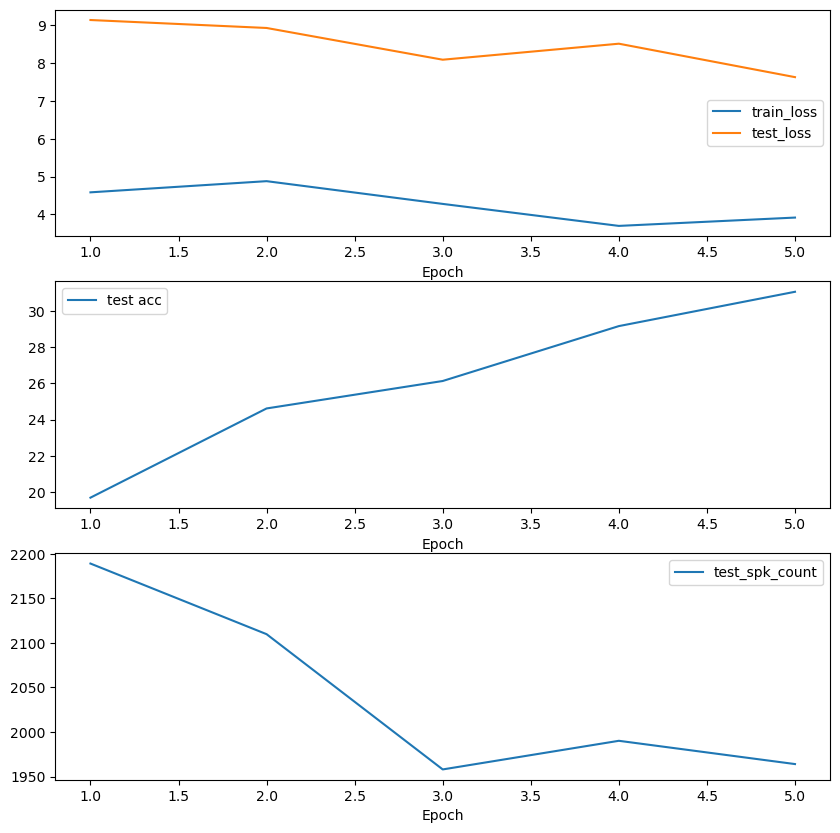

In [4]:
#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

TBD: 1D convolutions

In [7]:
import torch
import time
from snn_delays.snn import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils import train, get_device
from snn_delays.utils.test_behavior import tb_save_max_last_acc

'''
SHD dataset as in ablation study
'''

device = get_device()

# for reproducibility
torch.manual_seed(10)

dataset = 'shd'
total_time = 50
batch_size = 1024

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  crop_to=1e6)
train_loader, test_loader, dataset_dict = DL.get_dataloaders()
          
num_epochs = 50

lr = 1e-3
# SNN CON DELAYS
taimu1 = time.time()

tau_m = 'normal'
ckpt_dir = 'exp3_shd50_rnn' 

delay = (48, 16)

snn = SNN(dataset_dict=dataset_dict, structure=(64, 2), connection_type='f',
    delay=delay, delay_type='h', tau_m = tau_m,
    win=total_time, loss_fn='mem_sum', batch_size=batch_size, device=device,
    debug=False)

snn.set_network()

snn.to(device)
train(snn, train_loader, test_loader, lr, num_epochs, dropout=0.0, 
    test_behavior=tb_save_max_last_acc, ckpt_dir=ckpt_dir, scheduler=(100, 0.95), test_every=1)

Running on: cuda:0
[CropTime(min=0, max=1000000.0), ToFrame(sensor_size=(700, 1, 1), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]

[INFO] Delays: tensor([ 0, 16, 32])

[INFO] Delays i: tensor([0])

[INFO] Delays h: tensor([ 0, 16, 32])

[INFO] Delays o: tensor([0])
1000.0
Delta t: 20.0 ms
mean of normal: -0.541324854612918
training shd50_l2_48d16.t7 for 50 epochs...
Epoch [1/50], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
c:\Users\Alberto\anaconda3\envs\deepsnn\Lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to re

Step [2/7], Loss: 3.32567
l1_score: 0
Step [4/7], Loss: 3.24455
l1_score: 0
Step [6/7], Loss: 3.22454
l1_score: 0
Step [8/7], Loss: 3.16965
l1_score: 0
Time elasped: 66.01844072341919
Test Loss: 3.108332951863607
Avg spk_count per neuron for all 50 time-steps 3.688900947570801
Avg spk per neuron per layer [8.617567082597173, 6.138036936837456]
Test Accuracy of the model on the test samples: 5.698

Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp3_shd50_rnn
saving max acc: 5.6978798586572434
Model saved in  C:\Users\Alberto\OneDrive - UNIVERSIDAD DE SEVILLA\PythonData\Checkpoints\exp3_shd50_rnn
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [2/7], Loss: 3.07441
l1_score: 0
Step [4/7], Loss: 3.05801
l1_score: 0
Step [6/7], Loss: 3.01410
l1_score: 0
Step [8/7], Loss: 2.98190
l1_score: 0
Time elasped: 2.936033010482788
Test Loss: 2.9225052197774253
Avg spk_count per neuron for all 50 time-steps 3.4812538623809814
Avg spk per neuron per lay